In [138]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplcatppuccin
from mplcatppuccin.colormaps import get_colormap_from_list
from mplcatppuccin.palette import load_color

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

import warnings # necessary b/c pandas & statsmodels datetime issue
warnings.simplefilter(action="ignore")

import os

import sys
sys.path.append("..") # go to parent dir

from utils.currency_functions import league_df, trade_ratio, average_ratio, league_day

In [86]:
# This line is for our plot color schemes down the line.
mpl.style.use("mocha")

In [85]:
# List for all the colors we can use for our plots.
cat_color = ['rosewater', 'flamingo', 'pink', 'mauve', 'red', 'maroon', 'peach',
                 'yellow', 'green', 'teal', 'sky', 'sapphire', 'blue', 'lavender']

In [22]:
# List of the Currencies we will be studying.
currencies = ["Hunter's Exalted Orb", "Crusader's Exalted Orb", "Redeemer's Exalted Orb", "Warlord's Exalted Orb", "Awakener's Orb"]

In [73]:
# Code written by Joseph Nelson.

def interpret_dftest(dftest):
    '''
    This function takes the output of a adfuller test function and returns it as a pandas series.
    
    dftest: adfuller() function output.
    '''
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [118]:
def currency_dftest(currency, diffs=0):
    '''
    This function takes the adfuller test results for all leagues for a specified currency and stores them as
    a pandas dataframe.
    
    currency: specified currency
    diffs: default=0. differences to be tested.
    '''
    path = '../leagues/'
    result_df = pd.DataFrame()
    
    for league in os.listdir(path):
        df = league_df(league, currency)
        if df.empty:
            continue
        df = trade_ratio(df)
        df = average_ratio(df)
        
        if diffs>0:
            for i in range(0, diffs):
                df['Ratio'] = df['Ratio'].diff()
            df.dropna(inplace = True)
        
        adftest = interpret_dftest(adfuller(df['Ratio']))
        
        result_to_add = pd.DataFrame({
            'League': [league],
            'Currency': [currency],
            'Diff': [diffs],
            'Test Statistic': [adftest['Test Statistic']],
            'p-value': [adftest['p-value']]
        })
        result_df = pd.concat([result_df, result_to_add], ignore_index=True)
    
    return result_df

In [80]:
test_df = pd.DataFrame()

for currency in currencies:
    for i in range(0, 3):
        diffs = i
        test_df_add = currency_dftest(currency, diffs=diffs)
        test_df = pd.concat([test_df, test_df_add], ignore_index=True)
        
test_df

,League,Currency,Diff,Test Statistic,p-value
0,Sanctum,Hunter's Exalted Orb,0,-9.699851,1.079497e-16
1,Heist,Hunter's Exalted Orb,0,-1.348307,6.067927e-01
2,Metamorph,Hunter's Exalted Orb,0,-2.306097,1.700092e-01
3,Kalandra,Hunter's Exalted Orb,0,-1.876077,3.433978e-01
4,Harvest,Hunter's Exalted Orb,0,-0.914264,7.832386e-01
...,...,...,...,...,...
175,Ultimatum,Awakener's Orb,2,-5.863421,3.368672e-07
176,Archnemesis,Awakener's Orb,2,-5.054443,1.729803e-05
177,Expedition,Awakener's Orb,2,-7.404416,7.409263e-11
178,Scourge,Awakener's Orb,2,-6.113566,9.208689e-08


In [97]:
def currency_train_test_split(df):
    y_train, y_test = train_test_split(df['Ratio'], test_size = 0.1, shuffle = False)
    return y_train, y_test

In [98]:
def manual_grid_search(y_train, p_range=5, q_range=5, diffs=0):
    # Starting AIC, p, and q.
    best_aic = 999999999
    best_p = 0
    best_q = 0
    
    # Use nested for loop to iterate over values of p and q.
    for p in range(p_range):
        for q in range(q_range):
            
            # Insert try and except statements.
            try:
                
                # Instantiate ARIMA model.
                arima = ARIMA(endog = y_train, order = (p, diffs, q))
                
                # Fit ARIMA model.
                model = arima.fit()
   
                # Is my current model's AIC better than our best_aic?
                if model.aic < best_aic:
                    
                    # If so, let's overwrite best_aic, best_p, and best_q.
                    best_aic = model.aic
                    best_p = p
                    best_q = q
    
            except:
                pass
    print()
    print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
    print(f'This model has an AIC of {best_aic}.')
    return best_p, best_q

In [94]:
def arima_model(y_train, p, d, q):
    arima = ARIMA(endog = y_train, order = (p, d, q))
    
    model = arima.fit()
    
    return model

In [91]:
def arima_preds(model, y_test):
    # Generate predictions based on test set.
    preds = model.predict(start = y_test.index[0], end = y_test.index[-1])
    return preds

In [134]:
def plot_preds(y_train, y_test, preds, p, d, q, league, currency):
    plt.figure(figsize=(10,6))
    
    color1 = load_color("mocha", "blue")
    color2 = load_color("mocha", "yellow")
    color3 = load_color("mocha", "green")
    
    plt.plot(
        y_train.index, 
        y_train, 
        color = color1,
        label = 'Train'
    )
    
    plt.plot(
        y_test.index, 
        y_test, 
        color = color2,
        label = 'test'
    )
    
    plt.plot(
        y_test.index, 
        preds, 
        color = color3,
        label = 'preds'
    )
    
    plt.title(label = f'{league} {currency} ARIMA({p}, {d}, {q}) Predictions', fontsize=16)
    plt.legend()
    plt.show();

In [145]:
def full_model_proccess(currency):
    path = '../leagues/'
    for league in os.listdir(path):
        df = league_df(league=league, currency=currency)
        if df.empty:
            continue
        df = trade_ratio(df)
        df = average_ratio(df)
        df.set_index('Date', inplace=True)
        df.sort_index(inplace=True)
        
        y_train, y_test = currency_train_test_split(df)
        
        test_df
        
        filtered_df = test_df[(test_df['League'] == league) & (test_df['Currency'] == currency)]
        sorted_df = filtered_df.sort_values('p-value', ascending=True)
        diff = sorted_df.iloc[0]['Diff']
        diff
        
        p, q = manual_grid_search(y_train, p_range=5, q_range=5, diffs=diff)
        
        model = arima_model(y_train, p=p, d=diff, q=q)
        
        preds = arima_preds(model, y_test)
        print(f'The Mean Absolute Error is {mean_absolute_error(y_test, preds)}')
        print(f'The Mean Squared Error is {mean_squared_error(y_test, preds)}')
        
        plot_preds(y_train, y_test, preds=preds, p=p, d=diff, q=q, league=league, currency=currency)

<class 'pandas.core.frame.DataFrame'>
                 Ratio
Date                  
2022-12-10  115.500875
2022-12-11  151.956660
2022-12-12  141.886600
2022-12-13  143.572404
2022-12-14  145.468663

Our model that minimizes AIC on the training data is the ARIMA(2,1,3).
This model has an AIC of 744.9341421161384.
The Mean Absolute Error is 2.0373911969140672
The Mean Squared Error is 11.86246610842125


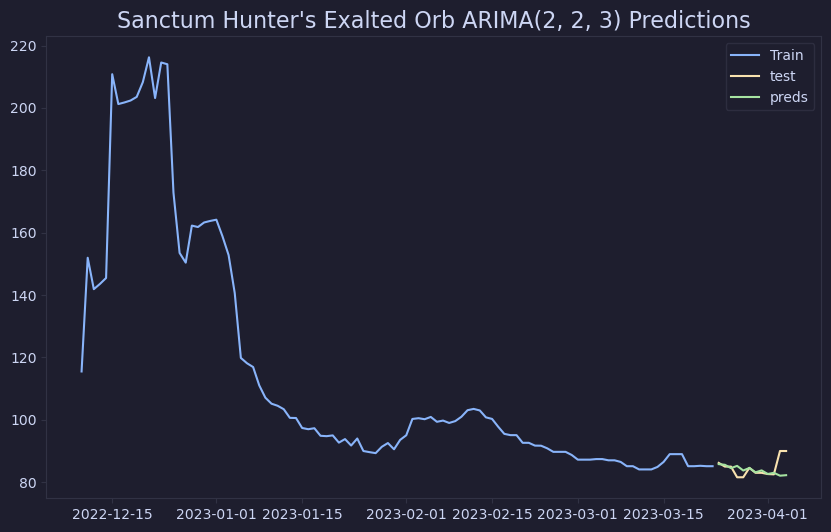

<class 'pandas.core.frame.DataFrame'>
                 Ratio
Date                  
2020-09-20  135.731461
2020-09-21  110.681210
2020-09-22  129.414534
2020-09-23  130.735043
2020-09-24  133.963843

Our model that minimizes AIC on the training data is the ARIMA(0,1,0).
This model has an AIC of 744.8208616455212.
The Mean Absolute Error is 10.812859188814123
The Mean Squared Error is 261.3146424206503


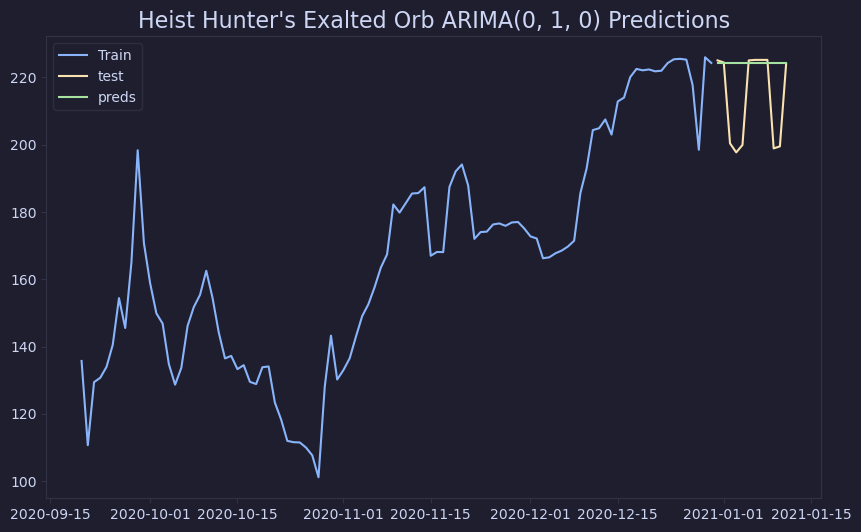

<class 'pandas.core.frame.DataFrame'>
                Ratio
Date                 
2019-12-20  406.99107
2019-12-21  371.00000
2019-12-22  436.00000
2019-12-23  457.40352
2019-12-24  354.00000

Our model that minimizes AIC on the training data is the ARIMA(0,1,4).
This model has an AIC of 765.2240082889635.
The Mean Absolute Error is 124.05417006171979
The Mean Squared Error is 17204.537090250073


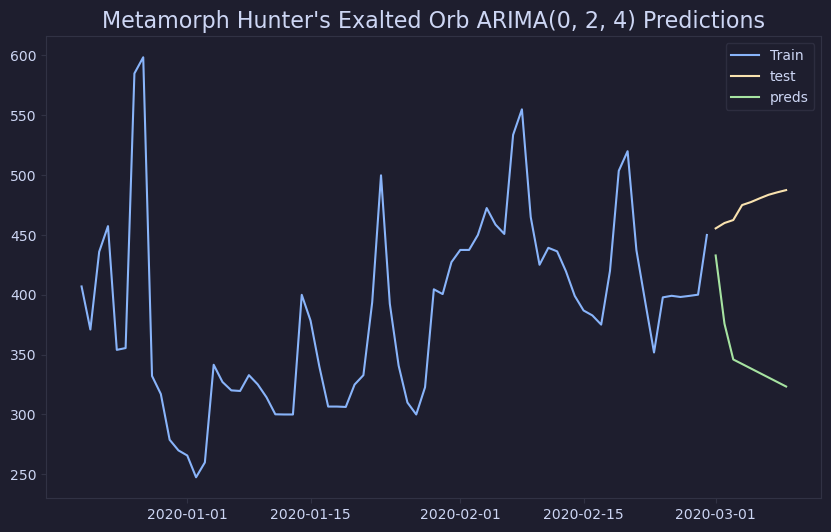

<class 'pandas.core.frame.DataFrame'>
                 Ratio
Date                  
2022-08-20   65.621905
2022-08-21   72.139590
2022-08-22  105.413261
2022-08-23  138.534083
2022-08-24  213.970689

Our model that minimizes AIC on the training data is the ARIMA(2,1,4).
This model has an AIC of 709.1068423919872.
The Mean Absolute Error is 6.74693869761006
The Mean Squared Error is 52.50980524819841


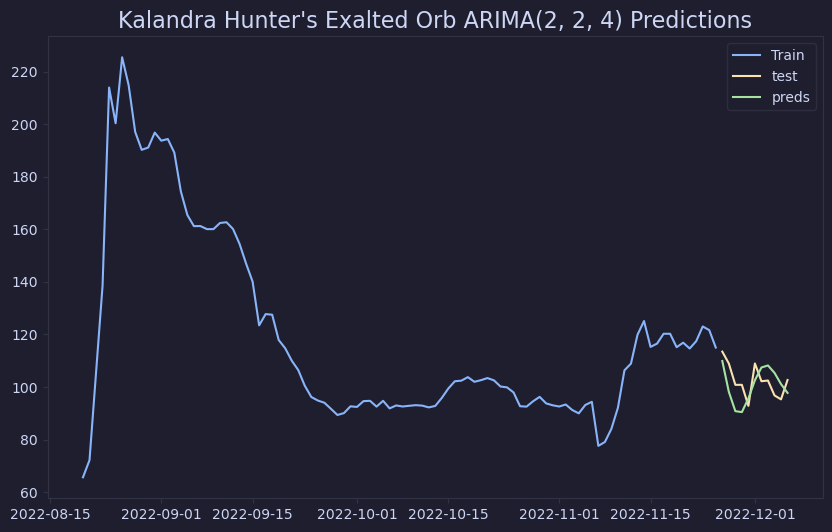

<class 'pandas.core.frame.DataFrame'>
                 Ratio
Date                  
2020-06-20  480.000000
2020-06-21  256.000000
2020-06-22  159.711704
2020-06-23  242.880742
2020-06-24  365.669878

Our model that minimizes AIC on the training data is the ARIMA(0,1,4).
This model has an AIC of 738.80779384939.
The Mean Absolute Error is 23.120199012654734
The Mean Squared Error is 689.0444263546281


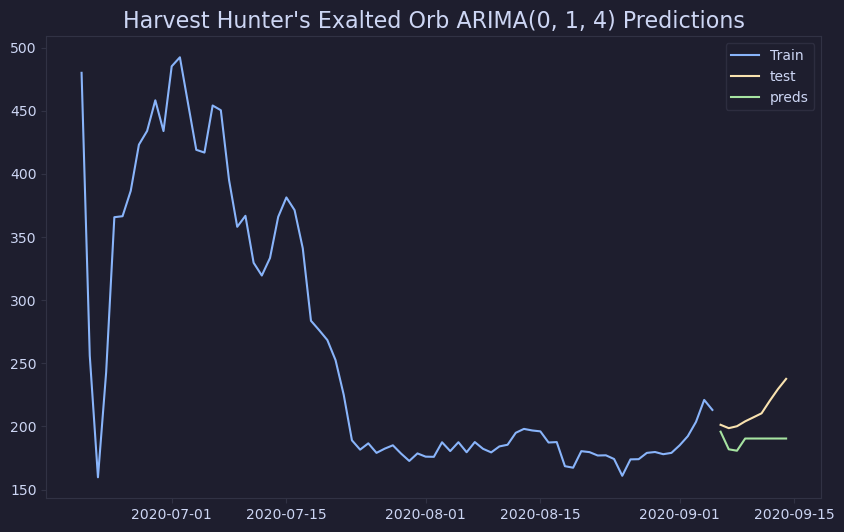

<class 'pandas.core.frame.DataFrame'>
                 Ratio
Date                  
2022-05-14  123.067500
2022-05-15   86.683825
2022-05-16  137.226421
2022-05-17  144.459492
2022-05-18  145.472292

Our model that minimizes AIC on the training data is the ARIMA(0,1,3).
This model has an AIC of 639.5259423493942.
The Mean Absolute Error is 51.865115905882384
The Mean Squared Error is 2902.5304887575394


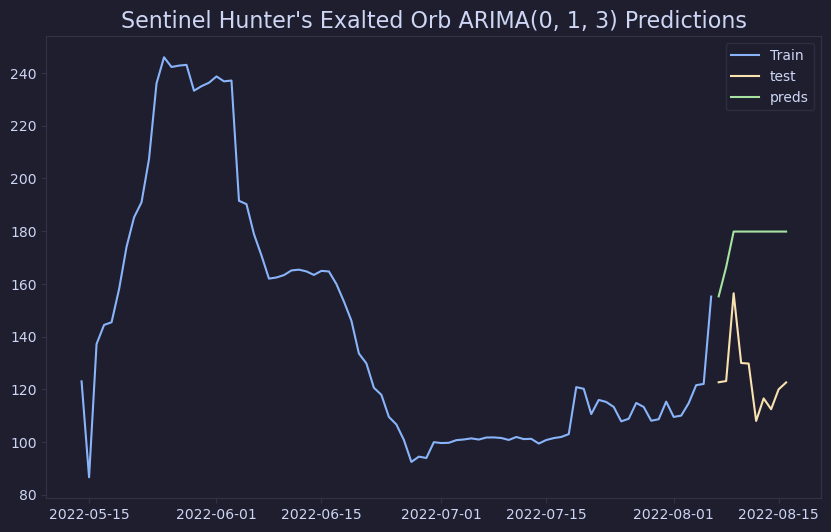

<class 'pandas.core.frame.DataFrame'>
                Ratio
Date                 
2020-03-15  340.00000
2020-03-16  307.50000
2020-03-17  362.14200
2020-03-18  372.00000
2020-03-19  354.69318

Our model that minimizes AIC on the training data is the ARIMA(2,1,3).
This model has an AIC of 787.4618582920442.


KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [144]:
for currency in currencies:
    full_model_proccess(currency)